In [2]:
## import dependencies 
import tensorflow as tf
import numpy as np 
import pandas as pd 
from datetime import datetime, date, time
import os 
import glob
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

In [3]:
## importing dependencies 
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS 

## define influxdb paramters
token = "A1hvR7pmPINW66Wuxbb7dpwR74TukBJIC7IuP3ADhr4xTx0Zzx-JZxzgInUUFbikMsg_bNo2TI4QnbXnUIOkDg=="
org = "ThirdYearProject"
bucket = "de75cd94d8127ada"

## connect to influxdb
client = InfluxDBClient(url="http://localhost:8086", token=token, org=org)

In [4]:
## query data

query_api = client.query_api()

query1 = 'from(bucket:"MicrosoftData")\
|> range(start:  2015-01-01T00:00:00Z, stop: 2015-11-01T11:59:59Z)\
|> filter(fn: (r) => r._measurement == "Network Prediction"\
and r.Channel == "channel_1303" and r.Segment == "34")\
|> pivot(rowKey:["_time"], columnKey:["_field"], valueColumn:"_value")\
|> keep(columns: ["_time", "Q-Factor"])'


def dataReady(query):
    data = query_api.query_data_frame(query)
    data.set_index("_time", inplace=True)
    data.index = pd.to_datetime(data.index)
    data.drop('result', axis=1, inplace=True)
    data.drop('table', axis=1, inplace=True)
    return data

data1  = dataReady(query1)

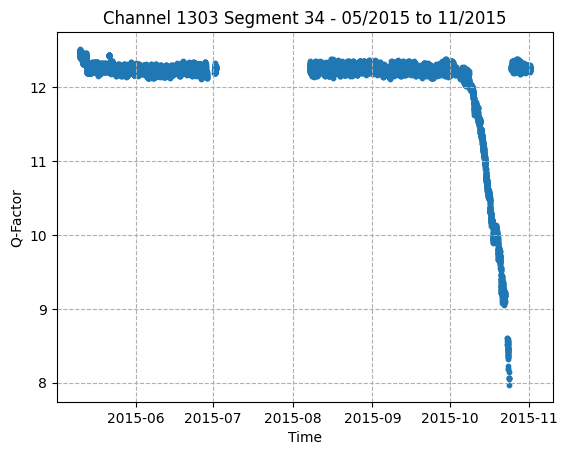

In [7]:
plt.scatter(data1.index, data1['Q-Factor'], s=10)
plt.xlabel('Time')
plt.ylabel('Q-Factor')
plt.title('Channel 1303 Segment 34 - 05/2015 to 11/2015')
plt.grid(linestyle="--")
plt.show()

In [8]:
#function to create input features
def ts_data_generator(data, window_size, batch_size, shuffle_buffer):
    ts_data = tf.data.Dataset.from_tensor_slices(data)
    ts_data = ts_data.window(window_size + 1, shift=1, drop_remainder=True)
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size+1))
    ts_data = ts_data.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    ts_data = ts_data.batch(batch_size).prefetch(1)
    return ts_data #expanding data into tensors 

## required parameters
WINDOW_SIZE = 335
BATCH_SIZE = 106
SHUFFLE_BUFFER = 12500

In [9]:
## converting data to numpy for better/faster processing 
time_index_data1 = np.array(data1.index)
data1_np = np.array(data1["Q-Factor"])

In [10]:
#splitting train into train/validation 
def splitData(data, time_index):
    n=len(data)
    train_data = data[:int(n*0.8)]
    train_time = time_index[:int(n*0.8)]
    val_data = data[int(n*0.8):int(n*0.83)]
    val_time = time_index[int(n*0.8):int(n*0.83)]
    test_data = data[int(n*0.83):]
    test_time = time_index[int(n*0.83):]
    return train_data, train_time, val_data, val_time, test_data, test_time

train_data1, train_time1, val_data1, val_time1, test_data1, test_time1 = splitData(data1_np, time_index_data1)
#train_data2, train_time2, val_data2, val_time2, test_data2, test_time2 = splitData(data2_np, time_index_data2)

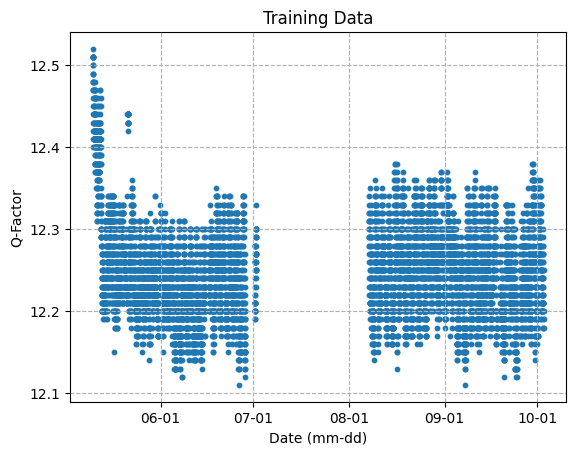

In [14]:
date_form = DateFormatter("%m-%d")
fig, ax = plt.subplots()
ax.scatter(train_time1, train_data1, s=10)
ax.set(xlabel="Date (mm-dd)", ylabel="Q-Factor")
ax.xaxis.set_major_formatter(date_form)
ax.grid(linestyle="--")
ax.set_title('Training Data')
plt.show()

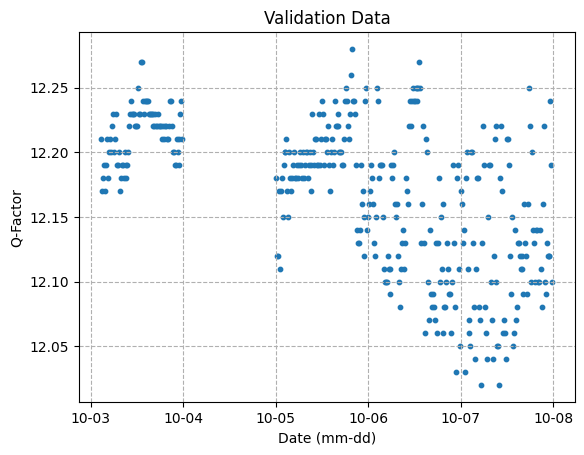

In [15]:
date_form = DateFormatter("%m-%d")
fig, ax = plt.subplots()
ax.scatter(val_time1, val_data1, s=10)
ax.set(xlabel="Date (mm-dd)", ylabel="Q-Factor")
ax.xaxis.set_major_formatter(date_form)
ax.grid(linestyle="--")
ax.set_title('Validation Data')
plt.show()

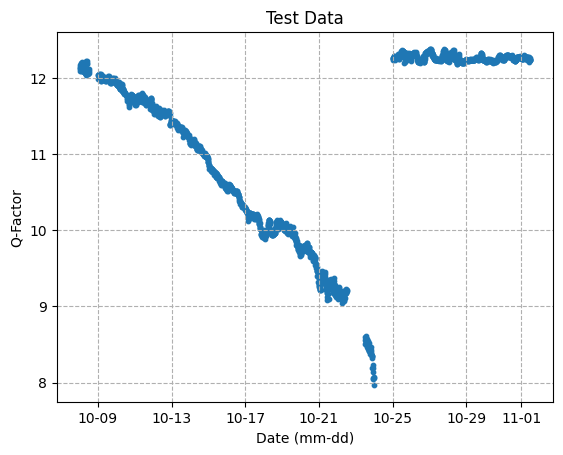

In [16]:
date_form = DateFormatter("%m-%d")
fig, ax = plt.subplots()
ax.scatter(test_time1, test_data1, s=10)
ax.set(xlabel="Date (mm-dd)", ylabel="Q-Factor")
ax.xaxis.set_major_formatter(date_form)
ax.grid(linestyle="--")
ax.set_title('Test Data')
plt.show()

In [16]:
# generating input and output features for training and testing set 
def tensorData(train_data, val_data):
    tensor_train_data = tf.expand_dims(train_data, axis=-1)
    tensor_val_data = tf.expand_dims(val_data, axis=-1)

    tensor_train_dataset = ts_data_generator(tensor_train_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
    tensor_val_dataset = ts_data_generator(tensor_val_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
    return tensor_train_dataset, tensor_val_dataset

tensor_train_dataset1, tensor_val_dataset1 = tensorData(train_data1, val_data1)


In [17]:
# building model 
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu",
        input_shape=[None,1]),
    tf.keras.layers.LSTM(128, return_sequences=True),

    tf.keras.layers.LSTM(128, return_sequences=True), 
    
    tf.keras.layers.LSTM(128, return_sequences=True), 
    
    tf.keras.layers.LSTM(128, return_sequences=True), 
    
    tf.keras.layers.Dense(60, activation="relu"),  

    tf.keras.layers.Dense(30, activation="relu"),  

    tf.keras.layers.Dense(10, activation="relu"), 

    tf.keras.layers.Dense(1)])

model.summary()

# optimiser algorithm adjust weights of network's neurons and learning rate
# reduces loss and improves overall accuracy
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(
   #lambda epoch: 1e-8 * 10 ** (epoch / 3))
    
optimiser = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimiser, metrics=[tf.keras.metrics.RootMeanSquaredError()])

## training model
history = model.fit(tensor_train_dataset1, epochs=20, validation_data=tensor_val_dataset1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 64)          384       
                                                                 
 lstm (LSTM)                 (None, None, 128)         98816     
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_3 (LSTM)               (None, None, 128)         131584    
                                                                 
 dense (Dense)               (None, None, 60)          7740      
                                                                 
 dense_1 (Dense)             (None, None, 30)          1

In [18]:
#determining optimum learning rate for model
#lrs = 1e-8 * (10**(np.arange(30)/3))
#plt.semilogx(lrs, history.history['loss'])
#plt.axis([1e-8, 1, 0, 15])
#plt.title('Determining Suitable Learning Rate')
#plt.xlabel('Learning Rate')
#plt.ylabel('Loss')
#plt.grid(linestyle="--")
#plt.show()

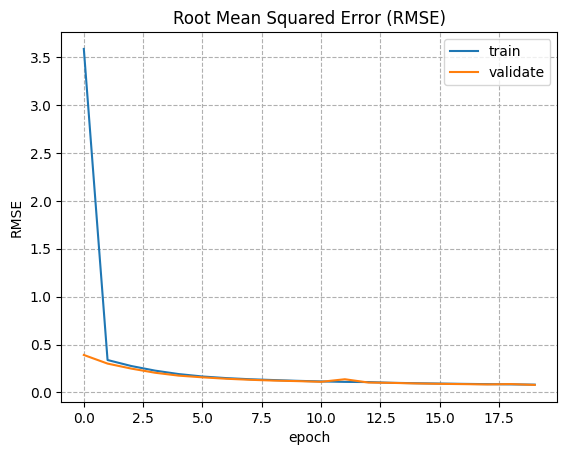

In [28]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.grid(linestyle="--")
plt.show()

In [29]:
#plt.plot(history.history['mae'])
#plt.plot(history.history['val_mae'])
#plt.title('Mean Absolute Error (MAE)')
#plt.ylabel('MAE')
#plt.xlabel('epoch')
#plt.legend(['train', 'validate'], loc='upper right')
#plt.grid(linestyle="--")
##plt.xlim(17,20)
#plt.show()

In [30]:
#plt.plot(history.history['mae'])
#plt.plot(history.history['val_mae'])
#plt.title('Mean Absolute Error (MAE)')
#plt.ylabel('MAE')
#plt.xlabel('epoch')
#plt.legend(['train', 'validate'], loc='upper right')
#plt.grid(linestyle="--")
#plt.xlim(17,20)
#plt.show()

In [31]:
## making a prediction
def model_forecast(model, data, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)#returns learned label for each object in array 
    #dimensions:(no. windows, window size, no. features)
    return forecast

#adding dimension to test_data so it matches 3 dimensional forecast
forecast = model_forecast(model, data1_np[...,np.newaxis], WINDOW_SIZE, BATCH_SIZE)

In [32]:
predicted_values = forecast[int(len(data1_np)*0.75)-WINDOW_SIZE:-1,-1,0]#batch size (: all) time slice (-1 last one) features (only one, so first one)

In [33]:
error = tf.keras.metrics.RootMeanSquaredError()
error.update_state(test_data1, predicted_values)
rmse = error.result().numpy()
print(rmse)

1.2451489


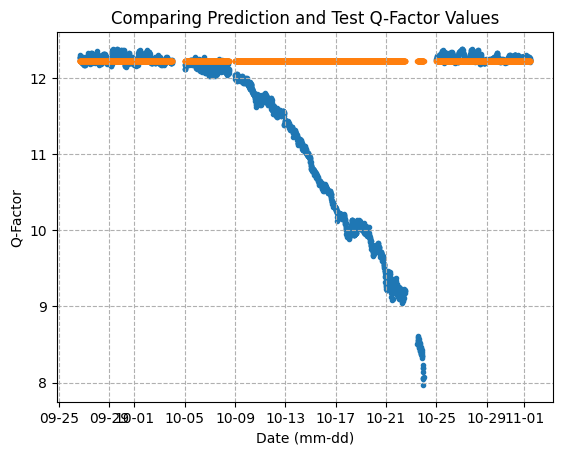

In [34]:
# comparison graph 
#plt.scatter(test_time1, test_data1, s=10)
#plt.scatter(test_time1, predicted_values, s=10)
#plt.title('Comparing Prediction & Test')
#plt.ylabel('Q-Factor')
#plt.xlabel('Time')
#plt.legend(['test', 'predictions'], loc='upper left')
#plt.show()
date_form = DateFormatter("%m-%d")
fig, ax = plt.subplots()
ax.scatter(test_time1, test_data1, s=9)
ax.scatter(test_time1, predicted_values, s=9)
ax.set(xlabel="Date (mm-dd)", ylabel="Q-Factor")
ax.xaxis.set_major_formatter(date_form)
ax.grid(linestyle="--")
ax.set_title('Comparing Prediction and Test Q-Factor Values')
plt.show()

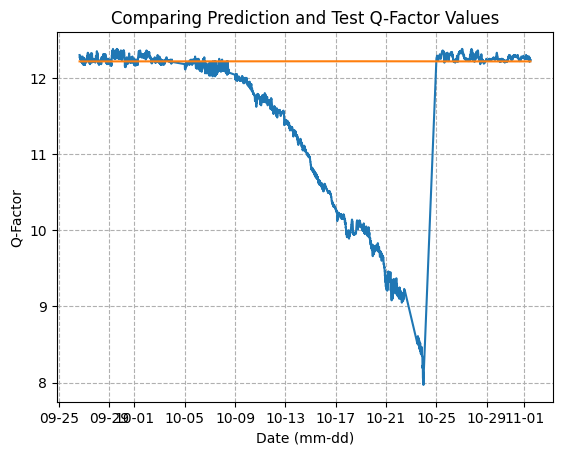

In [35]:
fig, ax = plt.subplots()
ax.plot(test_time1, test_data1)
ax.plot(test_time1, predicted_values)
ax.set(xlabel="Date (mm-dd)", ylabel="Q-Factor")
ax.xaxis.set_major_formatter(date_form)
ax.grid(linestyle="--")
ax.set_title('Comparing Prediction and Test Q-Factor Values')
plt.show()

In [36]:
#without dates comparison graph 
#plt.plot(test_data1)
#plt.plot(predicted_values)
#plt.title('Comparing Prediction & Test')
#plt.ylabel('Q-Factor')
#plt.xlabel('Time')
#plt.legend(['test', 'predictions'], loc='upper left')
#plt.show()